### **Transfer Learning**

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

In [13]:
# Create train_ds
data_dir = 'agri_crops/Agricultural-crops'
image_size = (224, 224)
batch_size = 10

train_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="training",
    shuffle=True,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    seed=42
)

#Create validation_ds
validation_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    shuffle=True,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    seed=42
)

# Define augmentation as a Sequential layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1),
    layers.GaussianNoise(0.02),
], name="data_augmentation")

# Extract class names
class_names = train_ds.class_names

# Apply data augmentation to the training set
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img, training=True), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 759 files belonging to 30 classes.
Using 608 files for training.
Found 759 files belonging to 30 classes.
Using 151 files for validation.


### **MobileNetV2**

In [6]:
def make_mobile_net_v2_model(input_shape, num_classes):
    backbone = keras.applications.MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )

    backbone.trainable = False  # Freeze base model

    inputs = keras.Input(shape=input_shape)
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs, name="mobilenetv2_model")

model_mbn_v2 = make_mobile_net_v2_model(input_shape=(224, 224, 3), num_classes=30)

In [7]:
# Compile and train frozen model
model_mbn_v2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

callbacks = [
    keras.callbacks.ModelCheckpoint("mobilenetv2_baseline_best.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
]

history_mbn_v2 = model_mbn_v2.fit(
    train_ds,
    epochs=50,
    validation_data=validation_ds,
    callbacks=callbacks,
)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 297ms/step - acc: 0.0709 - loss: 4.1051 - val_acc: 0.1987 - val_loss: 2.9905 - learning_rate: 3.0000e-04
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 276ms/step - acc: 0.2041 - loss: 2.8623 - val_acc: 0.4172 - val_loss: 2.3377 - learning_rate: 3.0000e-04
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - acc: 0.3690 - loss: 2.2628 - val_acc: 0.5629 - val_loss: 1.8435 - learning_rate: 3.0000e-04
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - acc: 0.4151 - loss: 2.0526 - val_acc: 0.5762 - val_loss: 1.6064 - learning_rate: 3.0000e-04
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 212ms/step - acc: 0.4551 - loss: 1.8735 - val_acc: 0.6093 - val_loss: 1.5405 - learning_rate: 3.0000e-04
Epoch 6/50


2025-07-19 20:38:56.317602: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 6021160 bytes after encountering the first element of size 6021160 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 296ms/step - acc: 0.5543 - loss: 1.6773 - val_acc: 0.6291 - val_loss: 1.4052 - learning_rate: 3.0000e-04
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step - acc: 0.5381 - loss: 1.6004 - val_acc: 0.6954 - val_loss: 1.3163 - learning_rate: 3.0000e-04
Epoch 8/50


2025-07-19 20:39:30.760491: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 6021160 bytes after encountering the first element of size 6021160 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - acc: 0.6152 - loss: 1.4124 - val_acc: 0.6821 - val_loss: 1.2740 - learning_rate: 3.0000e-04
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 247ms/step - acc: 0.6233 - loss: 1.3209 - val_acc: 0.6954 - val_loss: 1.1934 - learning_rate: 3.0000e-04
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 239ms/step - acc: 0.6475 - loss: 1.2607 - val_acc: 0.6954 - val_loss: 1.2238 - learning_rate: 3.0000e-04
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 236ms/step - acc: 0.6963 - loss: 1.1913 - val_acc: 0.7020 - val_loss: 1.1664 - learning_rate: 3.0000e-04
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 238ms/step - acc: 0.6794 - loss: 1.1837 - val_acc: 0.7351 - val_loss: 1.1361 - learning_rate: 3.0000e-04
Epoch 13/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 259ms/step - acc: 0.7122 - loss: 1.0566 - val_acc: 0.6954 - val_loss: 1.1567 - learning_rate: 3.0000e-04
Epoch 14/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 248ms/step - acc: 0.6841 - loss: 1.0691 - val_acc: 0.7152 - val_loss: 1.1427 - lea

2025-07-19 20:42:44.584145: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 6021160 bytes after encountering the first element of size 6021160 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


61/61 ━━━━━━━━━━━━━━━━━━━━ 1127s 19s/step - acc: 0.7837 - loss: 0.8118 - val_acc: 0.7483 - val_loss: 1.0803 - learning_rate: 1.5000e-04
Epoch 21/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - acc: 0.8131 - loss: 0.7169 - val_acc: 0.7285 - val_loss: 1.0821 - learning_rate: 1.5000e-04
Epoch 22/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 309ms/step - acc: 0.7838 - loss: 0.7991 - val_acc: 0.7285 - val_loss: 1.1218 - learning_rate: 1.5000e-04
Epoch 23/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - acc: 0.7885 - loss: 0.8070 - val_acc: 0.7351 - val_loss: 1.1104 - learning_rate: 1.5000e-04
Epoch 24/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 321ms/step - acc: 0.7838 - loss: 0.7406 - val_acc: 0.7285 - val_loss: 1.1008 - learning_rate: 7.5000e-05
Epoch 25/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - acc: 0.7666 - loss: 0.7974 - val_acc: 0.7219 - val_loss: 1.0964 - learning_rate: 7.5000e-05
Epoch 26/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 248ms/step - acc: 0.8255 - loss: 0.7546 - val_acc: 0.7152 - val_loss: 1.0899 - le

### **Train vs Validation Plot**

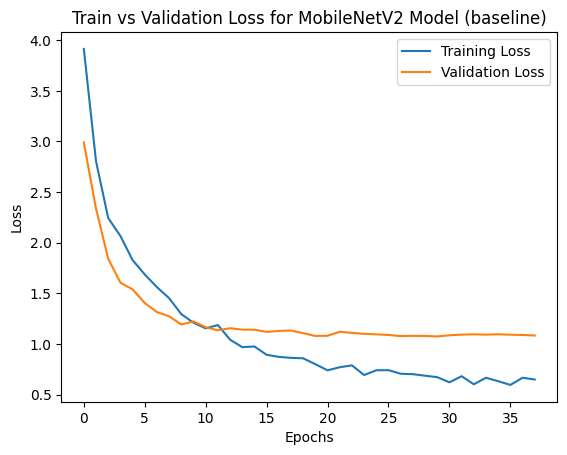

In [8]:
plt.plot(range(len(history_mbn_v2.history["loss"])), history_mbn_v2.history["loss"], label="Training Loss")
plt.plot(range(len(history_mbn_v2.history["val_loss"])), history_mbn_v2.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss for MobileNetV2 Model (baseline)")
plt.legend()
plt.show()

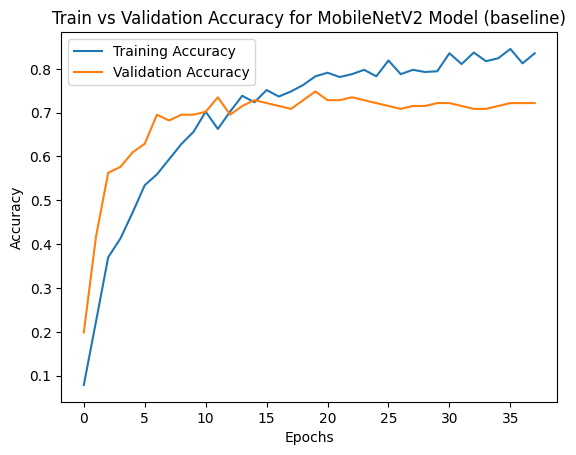

In [9]:
plt.plot(range(len(history_mbn_v2.history["acc"])),history_mbn_v2.history["acc"],label="Training Accuracy")
plt.plot(range(len(history_mbn_v2.history["val_acc"])),history_mbn_v2.history["val_acc"],label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy for MobileNetV2 Model (baseline)")
plt.legend()
plt.show()

### **Classification Report**

In [14]:
# Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Get true labels and predictions
y_true = []
y_pred = []

for batch_images, batch_labels in validation_ds:
    preds = model_mbn_v2.predict(batch_images)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
                     precision    recall  f1-score   support

             Cherry       0.60      0.43      0.50         7
       Coffee-plant       1.00      0.29      0.44         7
           Cucumber       0.71      0.83      0.77         6
   Fox_nut(Makhana)       1.00      0.57      0.73         7
              Lemon       0.67      0.80      0.73         5
         Oliv

2025-07-19 21:12:36.424238: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/landao/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/landao/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/landao/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_divisio